<a href="https://colab.research.google.com/github/PratikStar/google-colab/blob/main/1_Create_Audio_Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pipeline Classes

In [54]:
"""
1- load a file
2- pad the signal (if necessary)
3- extracting log spectrogram from signal
4- normalise spectrogram
5- save the normalised spectrogram

PreprocessingPipeline
"""
import os
import pickle
import re
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import inspect
import soundfile as sf

SHOW_LOGS = True
LOG_LEVEL = 1
def log(logline, log_level = 1):
    if SHOW_LOGS and log_level <= LOG_LEVEL:
        stack = inspect.stack()
        the_class = stack[1][0].f_locals["self"].__class__.__name__
        the_method = stack[1][0].f_code.co_name
        print(the_class + ": " + logline)

class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, offset, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.offset = offset
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              offset=self.offset,
                              mono=self.mono)[0]
        log("Shape of the loaded signal: " + str(signal.shape), 1)
        log("Mean of the loaded signal: " + str(np.mean(signal)), 5)
        log("Min of the loaded signal: " + str(np.amin(signal)), 5)
        log("Max of the loaded signal: " + str(np.amax(signal)), 5)
        log("Raw signal: " + str(signal), 5)
        return signal


class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        log("Shape of stft: " + str(stft.shape), 1)
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram

class FeatureExtractor:
    """ Extracts the required features"""

    def extract_ampid_from_name(self, filename):
        amp_id = int(filename.split('-')[0])
        log("Amp ID: " + str(amp_id), 5)
        return amp_id
    def extract_clipid_from_name(self, filename):
        clip_id = int(filename.split('-')[0])
        log("Clip ID: " + str(clip_id), 5)
        return clip_id

class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):

        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        log("Shape of norm_array: " + str(norm_array.shape), 1)
        log("Max of norm_array: " + str((array.max())), 5)
        log("Min of norm_array: " + str((array.min())), 5)
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


class Saver:
    """saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        Utils._create_folder_if_it_doesnt_exist(self.feature_save_dir)
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path

class Visualizer:
    def __init__(self, file_dir, frame_size, hop_length, offset):
        self.file_dir = file_dir
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.offset = offset
        pass
    
    def visualize(self, spectrogram, file_name):
        self.fig, self.ax = plt.subplots()
        img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=self.ax)
        self.ax.set_title("Frame Size: " + str(self.frame_size) + ", Hop Length: " + str(self.hop_length) + ", Offset: " + str(self.offset))
        self.fig.colorbar(img, ax=self.ax, format="%+2.0f dB")
        Utils._create_folder_if_it_doesnt_exist(self.file_dir)
        self.fig.savefig(os.path.join(self.file_dir, file_name + ".png"))

class Utils:
    def __init__(self):
        pass
    @staticmethod
    def _create_folder_if_it_doesnt_exist(folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

class AudioReconstructor:
    """Processes stft inverse and saves the audio file"""
    def __init__(self, file_dir, hop_length, frame_size):
        self.file_dir = file_dir
        self.hop_length = hop_length
        self.frame_size = frame_size

    def reconstruct(self, features, file_name):
        # Invert using Griffin-Lim
        log("Shape of features: " + str(features.shape), 1)
        features_inv = librosa.griffinlim(features,
                                          hop_length=self.hop_length,
                                          win_length=self.frame_size)
        log("Shape of Inverse features: " + str(features_inv.shape), 1)
        Utils._create_folder_if_it_doesnt_exist(self.file_dir)
        sf.write(os.path.join(self.file_dir, file_name ), y_inv, 22050)
        # save audio
    def reconstruct_from_path(self, file_path):
        # Invert using Griffin-Lim
        features = np.load(file_path)
        self.reconstruct(features, os.path.basename(file_path))
    
class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.feature_extractor = None
        self.normaliser = None
        self.saver = None
        self.visualizer = None
        self.reconstructor = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir, regex, number_of_clips, save_flg=True, visualize_flg=True):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                if re.match(regex, file) and number_of_clips > 0:
                    number_of_clips -= 1
                    self._process_file(root, file, save_flg, visualize_flg)
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_dir, file_name, save_flg, visualize_flg):
        file_path = os.path.join(file_dir, file_name)

        signal = self.loader.load(file_path)
        external_features = [ self.feature_extractor.extract_ampid_from_name(file_name),
                              self.feature_extractor.extract_clipid_from_name(file_name),                         
                            ]
        signal = np.concatenate((external_features, signal))

        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)

        norm_feature = self.normaliser.normalise(feature)

        # reconstructor.reconstruct(norm_feature, file_name)

        if visualize_flg:
            self.visualizer.visualize(norm_feature, file_name)

        if save_flg:
            save_path = self.saver.save_feature(norm_feature, file_path)
            self._store_min_max_value(save_path, feature.min(), feature.max())
        log(f"Processed file {file_name}", 5)

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            log("Padding necessary", 5)
            log("Signal: " + str(len(signal)), 5)
            log("Exp samples: " + str(self._num_expected_samples), 5)
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }


## Driver Code

In [53]:
FRAME_SIZE = 512
HOP_LENGTH = FRAME_SIZE // 2 # smaller better?
OFFSET = 0.5
DURATION = 0.74  # in seconds
SAMPLE_RATE = 22050
MONO = True

# Dimensions: (FRAME_SIZE / 2) x ceil(SAMPLE_RATE * DURATION / HOP_LENGTH)

AUDIO_FILES_DIR = "/content/drive/MyDrive/Music/VAE/audio/"
FILE_NAME_REGEX = ".*-01 .*\.wav$"

SPECTROGRAMS_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/spectrogram/"
SPECTROGRAMS_IMG_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/spectrogram-img/"
RECONSTRUCTED_AUDIO_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/audio-reconstructed/"
MIN_MAX_VALUES_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/"

NUMBER_OF_CLIPS = 1

# instantiate all objects
loader = Loader(SAMPLE_RATE, OFFSET, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
feature_extractor = FeatureExtractor()
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)
visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, HOP_LENGTH, OFFSET)
reconstructor = AudioReconstructor(RECONSTRUCTED_AUDIO_SAVE_DIR, HOP_LENGTH, FRAME_SIZE)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.feature_extractor = feature_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver
preprocessing_pipeline.visualizer = visualizer
preprocessing_pipeline.reconstructor = reconstructor

preprocessing_pipeline.process(AUDIO_FILES_DIR, FILE_NAME_REGEX, NUMBER_OF_CLIPS, save_flg=False, visualize_flg=False)

Loader: Shape of the loaded signal: (16317,)
LogSpectrogramExtractor: Shape of stft: (256, 64)
MinMaxNormaliser: Shape of norm_array: (256, 64)
AudioReconstructor: Shape of features: (256, 64)


ParameterError: ignored

### Trying to find optimal hop_length

In [ ]:

for i in range(256, 512, 20):
    break
    print(i)
    FILE_NAME_REGEX = "^00001-02 .*\.wav$"
    NUMBER_OF_CLIPS = 1
    OFFSET = 0.25

    loader = Loader(SAMPLE_RATE, OFFSET, DURATION, MONO)
    preprocessing_pipeline.loader = loader

    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, i)
    preprocessing_pipeline.extractor = log_spectrogram_extractor

    visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, i)
    preprocessing_pipeline.visualizer = visualizer

    preprocessing_pipeline.process(AUDIO_FILES_DIR, FILE_NAME_REGEX, NUMBER_OF_CLIPS)
    break

### Reconstruting the Audio

(198450,)
(1025, 388)
(198144,)


Text(0.5, 1.0, 'Magnitude-only istft reconstruction')

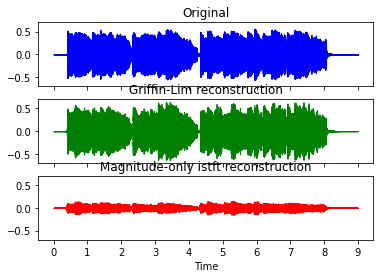

In [33]:
import soundfile as sf
y, sr = librosa.load('/content/drive/MyDrive/Music/VAE/audio/00001-01 01A US Double Nrm.wav')
print(y.shape)
# Get the magnitude spectrogram
S = np.abs(librosa.stft(y))
print(S.shape)



# Invert using Griffin-Lim
y_inv = librosa.griffinlim(S)
print(y_inv.shape)
sf.write('/content/drive/MyDrive/Music/VAE/sample.wav', y_inv, sr)


# Invert without estimating phase
y_istft = librosa.istft(S)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)


librosa.display.waveshow(y, sr=sr, color='b', ax=ax[0])
ax[0].set(title='Original', xlabel=None)
ax[0].label_outer()
librosa.display.waveshow(y_inv, sr=sr, color='g', ax=ax[1])
ax[1].set(title='Griffin-Lim reconstruction', xlabel=None)
ax[1].label_outer()
librosa.display.waveshow(y_istft, sr=sr, color='r', ax=ax[2])
ax[2].set_title('Magnitude-only istft reconstruction')

In [27]:
import soundfile as sf
data, samplerate = sf.read('/content/drive/MyDrive/Music/VAE/audio/00001-01 01A US Double Nrm.wav')
print(data)

librosa.output.write_wav('file_trim_5s.wav', y, sr)
print(samplerate)


[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 ...
 [-6.59232028e-05 -6.59232028e-05]
 [-6.61616214e-05 -6.61616214e-05]
 [-6.62808307e-05 -6.62808307e-05]]
44100
